# Assignment 1: CRF sequence tagging for Movie Queries

This coursework involves optimizing the performance of a **Conditional Random Field (CRF) sequence tagger** for movie trivia questions and answers data, which consist of instances of data of word sequences with the target classes/labels for each word in a **BIO (Beginning, Inside, Outside)** tagging format. 

This assignment involves reading in, pre-processing, training and developing your tagger on the training data from *trivia10k13train.bio.txt*, and finally testing your tagger on the data *trivia10k13test.bio.txt*, attempting to get the best performing tagger across the different labels in your development process. Parts of these steps have been done for you already. You are going to optimize the performance of the tagger by improving its feature extraction function on the word sequences, incorporating POS tagging first, then the final exercise is to optimize the performance by all legal means neccessary (except looking at the test data). Run and follow the code below and then attempt the questions.

**NOTEBOOK/CODE SUBMISSION: PLEASE SUBMIT IN NOTEBOOK FORM IF YOU CAN RATHER THAN IN A PYTHON FILE, MAKING YOUR CODE ADDITIONS TO THIS TEMPLATE FILE. SUBMISSION MUST BE IN PYTHON 3.7+ AND YOU MUST HAVE RUN THE CODE RUNNING FROM TOP TO BOTTOM BEFORE SUBMISSION.**

**WRITTEN REPORT SUBMISSION: YOU MUST INCLUDE A 2-PAGE MAX LENGTH REPORT SUMMARIZING HOW YOU WENT ABOUT ACHIEVING EACH QUESTION, TO BE SUBMITTED WITH YOUR CODE. PLEASE WRITE SUCCINCTLY AND CLEARLY, IN THE STYLE OF A SCIENTIFIC NLP CONFERENCE PAPER. AUTOMATIC PLAGIARISM DETECTION WILL BE RUN ON THESE FILES.**

In [1]:
# You may need to run this first- uncomment if so
!pip install python-crfsuite

In [2]:
import os
import sys

from copy import deepcopy
from collections import Counter
from nltk.tag import CRFTagger

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report

from matplotlib import pyplot as plt
import numpy as np

import re
import unicodedata

In [3]:
def get_raw_data_from_bio_file(fpath):
    """A simple function to read in from a one-word-per-line BIO
    (Beginning, Inside, Outside) tagged corpus, tab separated
    and each example sentence/text separated with a blank line.
    The data is already tokenized in a simple way.
    e.g.:
    
    B-Actor	steve
    I-Actor	mcqueen
    O	provided
    O	a
    B-Plot	thrilling
    I-Plot	motorcycle
    I-Plot	chase
    I-Plot	in
    I-Plot	this
    B-Opinion	greatest
    I-Opinion	of
    I-Opinion	all
    B-Plot	ww
    I-Plot	2
    I-Plot	prison
    I-Plot	escape
    I-Plot	movies
    
    returns a list of lists of tuples of (word, tag) tuples
    """
    f = open(fpath)
    data = []  # the data, a list of lists of (word, tag) tuples
    current_sent = []  # data for current sentence/example
    for line in f:
        if line == "\n":  # each instance has a blank line separating it from next one
            # solution
            data.append(current_sent)
            current_sent = []
            continue
        line_data = line.strip("\n").split("\t")
        current_sent.append((line_data[1], line_data[0]))
    f.close()
    return data

In [4]:
raw_training_data = get_raw_data_from_bio_file("trivia10k13train.bio.txt")

In [5]:
# have a look at the first example
print(raw_training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [6]:
print(len(raw_training_data), "instances")
print(sum([len(sent) for sent in raw_training_data]), "words")

7816 instances
158823 words


In [7]:
def preProcess(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words"""

    preprocessed_example = example  # trivial- no preprocessing
    return preprocessed_example

In [8]:
training_data = [preProcess(example) for example in raw_training_data]

In [9]:
# check the effect of pre-processing
print(training_data[0])

[('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'), ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'), ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'), ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'), ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'), ('escape', 'I-Plot'), ('movies', 'I-Plot')]


In [10]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token[-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token[-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token[-3:])
        
    feature_list.append("WORD_" + token)
    #print(feature_list)
    return feature_list

In [11]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger"  # path to the tagger- it will save/access the model from here
ct = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
ct.train(training_data, TAGGER_PATH)
print("done")

training tagger...
done


In [12]:
# let's see how it does in testing on sentences
def print_tags(sentence):
    # a method to print out the sequence with its tags
    tokens = sentence.split()
    tags = [p[1] for p in ct.tag(tokens)]
    for token, tag in zip(tokens, tags):
        print(f'{token:12s}{tag}')

In [13]:
# an example from the corpus
example = "steve mcqueen provided a thrilling motorcycle chase in this greatest of all ww 2 prison escape movies"
print_tags(example)

steve       B-Actor
mcqueen     I-Actor
provided    O
a           B-Plot
thrilling   I-Plot
motorcycle  I-Plot
chase       I-Plot
in          I-Plot
this        I-Plot
greatest    I-Plot
of          I-Plot
all         I-Plot
ww          I-Plot
2           I-Plot
prison      I-Plot
escape      I-Plot
movies      I-Plot


In [14]:
# a novel, unseen example we've just made up
print_tags("batman is the main character in batman begins")

batman      O
is          O
the         O
main        O
character   O
in          O
batman      B-Character_Name
begins      I-Character_Name


In [15]:
# another example
print_tags("the sound of music")

the         O
sound       O
of          O
music       O


In [16]:
# load tagger from saved file
ct = CRFTagger(feature_func=get_features)  # initialize tagger
ct.set_model_file(TAGGER_PATH)  # load model from file

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
test_data = [preProcess(example) for example in raw_test_data]
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")

1953 instances
39035 words


In [17]:
print("testing tagger...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

testing tagger...
done


In [18]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds, zero_division=0))
print(precision_recall_fscore_support(y_test, preds, average='macro',zero_division=0))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.86      0.88      0.87      1274
         B-Award       0.72      0.62      0.67        66
B-Character_Name       0.81      0.24      0.37       283
      B-Director       0.84      0.72      0.78       425
         B-Genre       0.83      0.76      0.79       789
       B-Opinion       0.49      0.30      0.37       195
        B-Origin       0.52      0.38      0.44       190
          B-Plot       0.49      0.47      0.48      1577
         B-Quote       0.75      0.26      0.38        47
  B-Relationship       0.80      0.53      0.64       171
    B-Soundtrack       0.00      0.00      0.00         8
          B-Year       0.94      0.97      0.96       661
         I-Actor       0.86      0.89      0.87      1553
         I-Award       0.74      0.69      0.72       147
I-Character_Name       0.84      0.29      0.43       227
      I-Director       0.89      0.74      0.81       411
         I-Ge

In [19]:
from sklearn.metrics import confusion_matrix
def confusion_matrix_heatmap(y_test, preds):
    """Function to plot a confusion matrix"""
    labels = list(set(y_test))   # get the labels in the y_test
    print(labels)
    cm = confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")

    plt.xlabel('Predicted')
    plt.ylabel('True')
    #fig.tight_layout()
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!

['B-Quote', 'I-Award', 'I-Year', 'I-Plot', 'B-Director', 'O', 'B-Year', 'B-Genre', 'B-Character_Name', 'I-Origin', 'B-Opinion', 'I-Soundtrack', 'B-Actor', 'B-Soundtrack', 'I-Quote', 'I-Relationship', 'I-Actor', 'B-Relationship', 'I-Director', 'B-Origin', 'I-Genre', 'B-Plot', 'I-Character_Name', 'B-Award', 'I-Opinion']


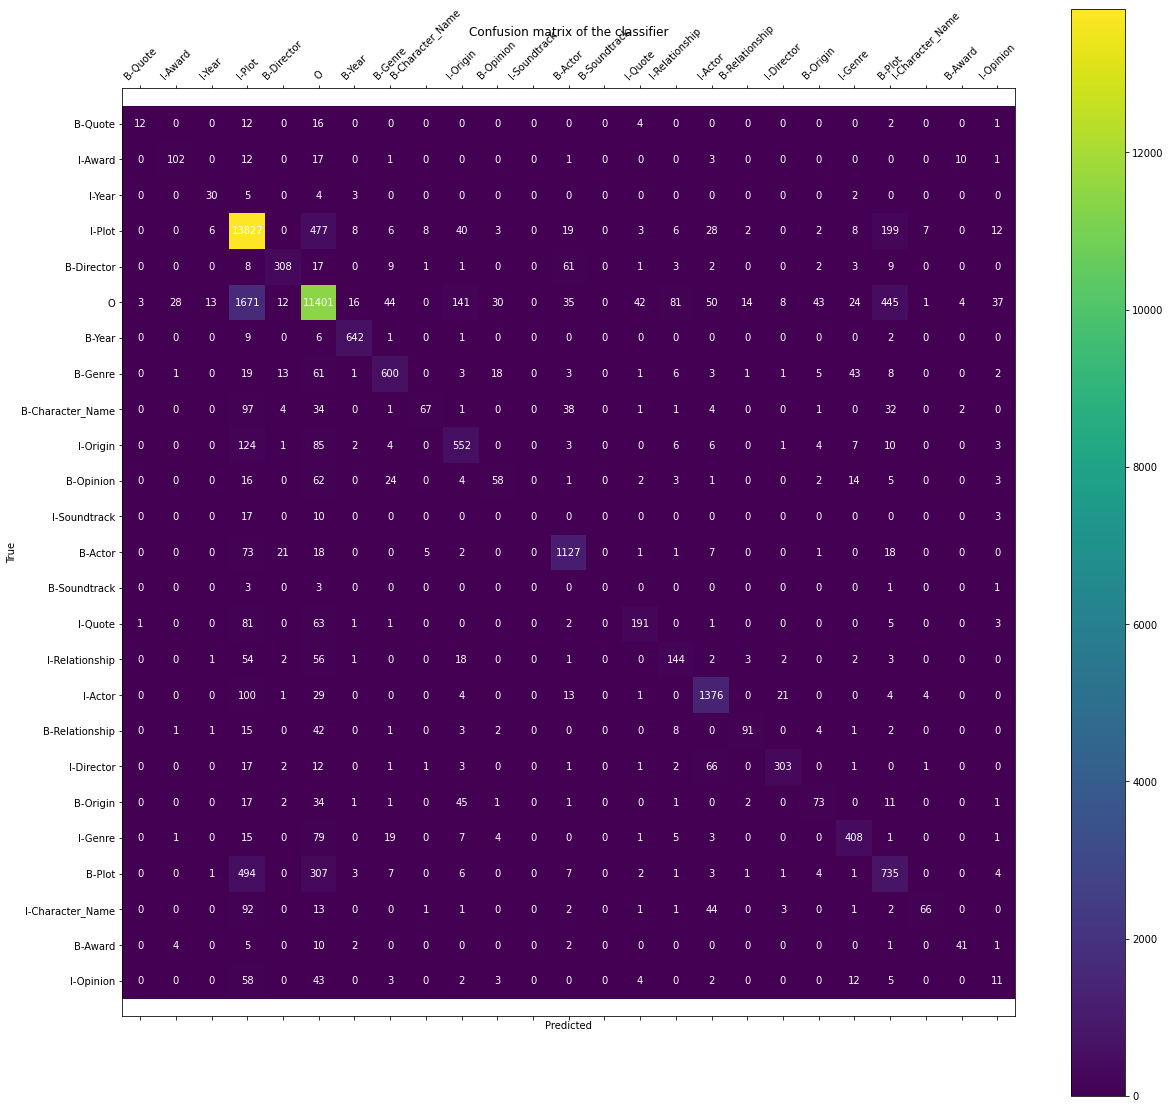

In [20]:
confusion_matrix_heatmap(y_test, preds)

In [21]:
# Let's see what the CRF learned by looking at the internal transition/feature weights....

In [22]:
def print_transition_weights(transitions):
    """Sort the transitions between states/labels from highest to
    lowest strengths and print out."""
    ranked_transitions = [x for x in sorted(transitions,
                                               key=lambda x:x[1], reverse=True)]
    for (label_from, label_to), weight in ranked_transitions:
        print("%0.6f %-8s -> %s" % (weight, label_from, label_to))

In [23]:
print_transition_weights(ct._tagger.info().transitions.items())

8.724577 B-Actor  -> I-Actor
8.339819 B-Plot   -> I-Plot
8.056264 B-Director -> I-Director
7.844567 B-Origin -> I-Origin
7.724763 I-Plot   -> I-Plot
7.553570 I-Quote  -> I-Quote
7.397641 B-Character_Name -> I-Character_Name
7.342680 I-Origin -> I-Origin
7.263004 B-Relationship -> I-Relationship
7.140895 B-Quote  -> I-Quote
7.013351 I-Relationship -> I-Relationship
6.867795 I-Soundtrack -> I-Soundtrack
6.788047 I-Opinion -> I-Opinion
6.732937 B-Genre  -> I-Genre
6.693016 B-Soundtrack -> I-Soundtrack
6.578020 B-Award  -> I-Award
6.435503 B-Opinion -> I-Opinion
6.422268 I-Award  -> I-Award
6.355522 I-Genre  -> I-Genre
6.344544 I-Actor  -> I-Actor
6.220084 I-Character_Name -> I-Character_Name
5.427243 I-Director -> I-Director
4.815258 I-Year   -> I-Year
4.083843 B-Year   -> I-Year
3.776230 B-Character_Name -> B-Plot
3.564706 O        -> O
3.561946 I-Character_Name -> B-Plot
3.277159 O        -> B-Plot
3.197475 B-Plot   -> B-Character_Name
3.085634 B-Opinion -> B-Genre
3.028571 O        -> 

In [24]:
def print_most_predictive_state_features(state_features,
                                         excluded_classes=["O"],
                                         top_k=None):
    """Takes in the dict of state_features from a python crf-suite tagger,
    orders them in terms of how predictive they are of different classes.
    We assume we are not interested in O labels."""
    if not top_k:
        top_k = len(state_features)  # assume we want to print all of them
    ranked_state_features = [x for x in sorted(state_features, key=lambda x:x[1], reverse=True) \
         if x[0][1] not in excluded_classes][:top_k]
    for (attr, label), weight in ranked_state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

In [25]:
print_most_predictive_state_features(ct._tagger.info().state_features.items())

Streaming output truncated to the last 5000 lines.
0.013258 I-Plot   WORD_polluted
0.013211 I-Plot   WORD_expedition
0.013197 B-Character_Name SUF_red
0.013182 B-Plot   SUF_rns
0.013164 I-Plot   SUF_fee
0.013164 I-Plot   WORD_coffee
0.013141 I-Plot   SUF_edo
0.013129 I-Plot   WORD_behalf
0.013113 B-Plot   WORD_documents
0.013078 I-Plot   WORD_farmboy
0.013059 I-Actor  SUF_fia
0.013046 I-Plot   WORD_materials
0.013036 I-Plot   WORD_naked
0.013034 I-Plot   WORD_attic
0.013004 I-Plot   WORD_gravely
0.012983 I-Award  SUF_ous
0.012973 I-Plot   WORD_idealism
0.012969 B-Quote  SUF_ed
0.012968 I-Plot   WORD_tanked
0.012964 I-Plot   WORD_expense
0.012921 I-Plot   SUF_iya
0.012921 I-Plot   WORD_wadiya
0.012919 I-Plot   WORD_agency
0.012881 I-Plot   SUF_urt
0.012880 I-Plot   WORD_gig
0.012871 I-Plot   WORD_orchestrated
0.012843 I-Plot   WORD_suspension
0.012835 B-Character_Name WORD_sugar
0.012830 I-Plot   WORD_fend
0.012828 I-Plot   WORD_recounts
0.012805 I-Plot   WORD_solely
0.012792 I-Plot   W

# 1. Split the training data into 80% training, 20% development set (5 marks)
Split the training data (`training_data`) into two lists: one split of the first 80% of the instances of `training_data`, which you will use for training your CRF, and the remaining 20% for testing. Once you've done this re-run the above code such that the tagger is trained on the 80% split and tested on the 20% split, and you obtain the classification report output and confusion heatmap output for the results of testing. Do not use the test data as it is above for testing/viewing results for now. Record the results by saving the classification report output as a string somewhere in the notebook for future reference as you go through.


#Solution 1

##Step 1: Splitting the Data


---


Training data is split into 2 parts:
1.   New Training Set
2.   Development Set

A new training set has been created by extracting the first 80% of the complete training data, so that our model is trained on the enough samples and rest 20% of the data can be used for validation purposes. This is an important step as the 20% of the data which is used here as a development data contains the true labels and it would be treated as an unseen data by the model. So predicted values on this unseen data can be compared with the ground truth values to check the performance and accuracy of our model.

Slicing of the list has been used to split the data into required datasets to avoid randomnes as shown below:

In [26]:
# Splitting the data as first 80% into new training data and rest of the 20% as new development data
new_training_data = training_data[: int(len(training_data)*0.80)]
new_development_data = training_data[int(len(training_data)*0.80):]
print("Length of Training Data: {}".format(len(training_data)))
print("Length of New Training Data: {} (first 80% of the training data)".format(len(new_training_data)))
print("Length of New Developement Data: {} (remaining 20% of the training data)".format(len(new_development_data)))


Length of Training Data: 7816
Length of New Training Data: 6252 (first 80% of the training data)
Length of New Developement Data: 1564 (remaining 20% of the training data)


##Step 2: Train the model

New copy of the model has been trained on the 80% training data i.e. New Training Data.

In [27]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger_80percent"  # path to the tagger- it will save/access the model from here
ct1 = CRFTagger(feature_func=get_features)  # initialize tagger with get_features function

print("training tagger...")
# Train the tagger on the new training data which 80% of the whole training data
ct1.train(new_training_data, TAGGER_PATH)
print("done")

training tagger...
done


##Step 3: Test the model

Tagger model saved in step 2 to be used to test the model on the 20% of the actual training data i.e. New Development Data.


In [28]:
# load tagger from saved file
ct1 = CRFTagger(feature_func=get_features)  # initialize tagger
ct1.set_model_file(TAGGER_PATH)  # load model from file

#Use Development data as new test data
print(len(new_development_data), "instances")
print(sum([len(sent) for sent in new_development_data]), "words")

# Testing the tagger on new development data which 20% of the actual training data.
print("testing tagger...")
preds = []
y_test = []
for sent in new_development_data:
    sent_preds = [x[1] for x in ct1.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("Test Completed!")

1564 instances
31304 words
testing tagger...
Test Completed!


##Step 4: Analyze the results

Check the classification report of the model to see the precision, recall, and f1 score for each class. These are the important parameters used for checking the accuracy of the model.
Also, print the confusion matrix heatmap to understand the number of misclassified objects for each class.

Confusion matrix illustrates that the precision and recall values have been improved slightly for most of the classes. However, downfall is observed in precision for B-Character Name, I-Character Name classes.

Overall accuracy has been slightly improved whereas the Average F1 score has been slightly decreased by this split.

Splitting the data can cause these changes as it depends on the data which a model is trained on and thus can perform accordingly.

In [29]:
# Saving the Classification Report Output as a string below
classification_report_output_string = classification_report(y_test, preds, zero_division=0)
# Output the classification report (which you should save each time for comparing your models)
print(classification_report_output_string)
print(precision_recall_fscore_support(y_test, preds, average='macro', zero_division=0))  # print out accurate macro score
print("Classification report saved as : {} in the variable 'classification_report_output_string'".format(type(classification_report_output_string)))

                  precision    recall  f1-score   support

         B-Actor       0.87      0.87      0.87      1231
         B-Award       0.76      0.60      0.67        75
B-Character_Name       0.65      0.13      0.22       212
      B-Director       0.86      0.67      0.75       472
         B-Genre       0.86      0.78      0.82       805
       B-Opinion       0.47      0.23      0.30       160
        B-Origin       0.58      0.44      0.50       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.82      0.41      0.55       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.89      0.84      0.87      1731
         I-Award       0.79      0.81      0.80       202
I-Character_Name       0.61      0.12      0.20       165
      I-Director       0.86      0.66      0.75       456
         I-Ge

['B-Quote', 'I-Award', 'I-Year', 'I-Plot', 'B-Director', 'O', 'B-Year', 'B-Genre', 'B-Character_Name', 'I-Origin', 'B-Opinion', 'I-Soundtrack', 'B-Actor', 'B-Soundtrack', 'I-Quote', 'I-Relationship', 'I-Actor', 'B-Relationship', 'I-Director', 'B-Origin', 'I-Genre', 'B-Plot', 'I-Character_Name', 'B-Award', 'I-Opinion']


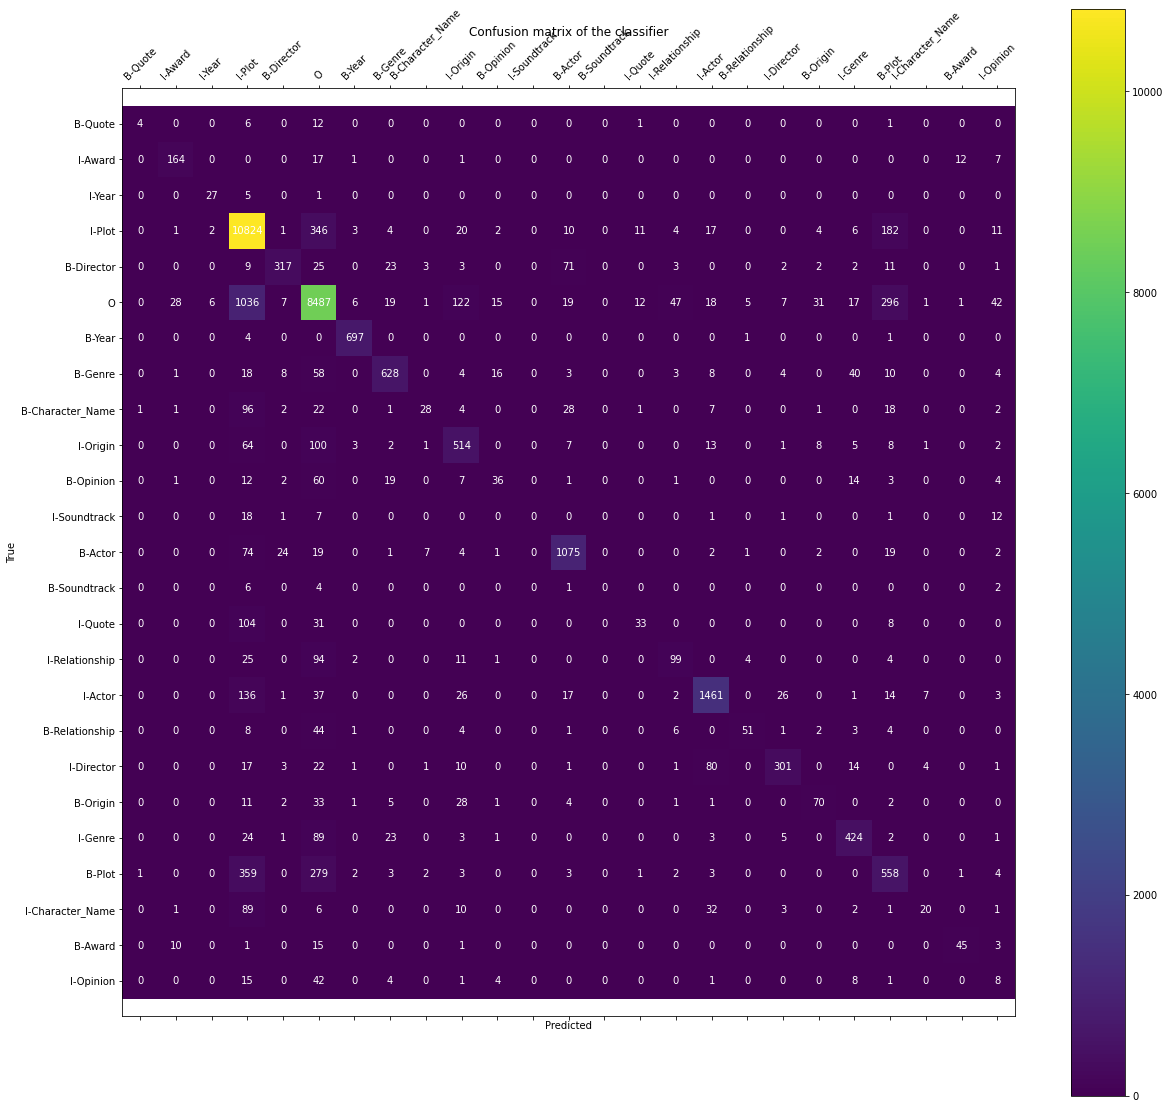

In [30]:
# Generate Confusion Matrix heatmap for new test data
confusion_matrix_heatmap(y_test, preds)

# 2. Error analysis 1: False positives (5 marks)

Performing error analyses is a key part of improving your NLP applications. For the 5 classes which have the lowest precision, according to the results table from your 20% development data, print out all the sentences where there is a false positive for that class (i.e. the label is predicted in the predicted label for a given word by the tagger, but this is not present in the corresponding ground truth label for that word). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


#Solution 2

##Step 1: Get 5 Classes with the least Precision values

To extract the 5 classes with the least precision values, the Classification report is converted into a dictionary where keys are the classes and values are the precision values of the respective class.

Dictionary has been sorted in an ascending order and the top 5 classes have been extracted as shown below:

Analyzing the classes with the least precision values is important as this determines the classes where the model is most confused and is not able to classify the correct class.

tabulate function of tabulate library is used to display the classes with their precision values in a tabular format

In [31]:
from tabulate import tabulate
#Precision value for each class:
classification_report_output_dict = classification_report(y_test, preds, output_dict=True, zero_division=0)
class_precision_dict = {}
for key in classification_report_output_dict.keys():
  if key.startswith(('B-', 'I-', 'O')): #Sropping Accuracy, weight avg, keys
    class_precision_dict[key] = classification_report_output_dict[key]['precision']

#Dictionary with Least Precision Classes with their values
least_precision_class = dict(sorted(class_precision_dict.items(), key=lambda item: item[1])[0:5])
print("Top 5 classes with least precision values: ")
print(tabulate(least_precision_class.items(), headers=['Class', 'Precision']))

Top 5 classes with least precision values: 
Class           Precision
------------  -----------
B-Soundtrack    0
I-Soundtrack    0
I-Opinion       0.0727273
B-Opinion       0.467532
B-Plot          0.487762


##Step 2: Identify False Positives for 5 least precision classes

Below code checks each sentence and identifies any word in the sentence if it has been <b>Falsely classified into one of the 5 classes with the least precision values</b>

Approach: Loop over all the sentences and fetch words, their predicted value and the true value from the new development data (whihc is 20% of the initial training data). Loop over each word and check if it has been predicted as one of the classes with the least precision values and whether its true label is not the same as the predicted value. If yes, mark the word as False positive in the given and sentence. 

Dataframe has been created for each sentence that contains at least one false-positive and determines all the False positive words in that sentence. Dataframes are printed with a <b>tabulate</b> function which transforms the dataframe into a tabular format.

In [32]:
import pandas as pd
pd.set_option('max_colwidth', 400)
from tabulate import tabulate

total_fp_sentences = 0 # Counter for number of sentence with False Positive words of 5 least precision classes
total_fp_words = 0 # Counter for number of False Positive words of 5 least precision classes
fp_words_for_each_class = dict.fromkeys(least_precision_class.keys(), 0) # Dictionary to check number of false positive words for each class
df_fp_word_frequency = pd.DataFrame(columns=["Word", "True Label", "Predicted Value", "Sentence", "Index in Sent"])# dataframe to record the frequency of each false positive word

for sent in new_development_data:
  fp_sentence = False
  t = [s[0] for s in sent]
  s_pred = [x[1] for x in ct1.tag(t)]
  s_true = [s[1] for s in sent]
  df1 = pd.DataFrame(columns=['Word', 'True Label', 'Predicted Value', "Error"])
  for i in range(len(t)):
    # If a predicted value is among the least precision classes and true label is not same as predicted value.
    if (s_pred[i] in least_precision_class.keys()) and (s_pred[i] != s_true[i]):
      false_pos_row = [t[i], s_true[i], s_pred[i], "False Positive"]
      total_fp_words += 1
      df1.loc[len(df1)] = false_pos_row
      fp_words_for_each_class[s_pred[i]] = fp_words_for_each_class.get(s_pred[i]) + 1
      fp_sentence = True

      #Add words in the dataframe from all the sentences:
      df_fp_word_frequency.loc[len(df_fp_word_frequency)] = [t[i], s_true[i], s_pred[i], " ".join(t), str(i)]
    else:
      true_row = [t[i], s_true[i], s_pred[i], ""]
      df1.loc[len(df1)] = true_row

  if fp_sentence:
    print("Sentence with FP" + str(t))
    print("Details of FP Values:")
    print(tabulate(df1, headers = 'keys', tablefmt = 'psql'))
    total_fp_sentences += 1
    print("*"*150)
print("*"*150)
print("Dataframe for all the False Positive words: ")
display(df_fp_word_frequency)
print("*"*150)
print("Frequency of all false positive words: ")
print(df_fp_word_frequency['Word'].value_counts())
print("*"*150)
print("Number of sentences with FP from least precision classes: " + str(total_fp_sentences))
print("Number of False Positive words in these sentences: " + str(total_fp_words))
print("Number of False Positive words for each class: {}".format(fp_words_for_each_class))
print("*"*150)
print("Done")

Streaming output truncated to the last 5000 lines.
| 14 | a        | I-Plot       | I-Plot            |                |
| 15 | car      | I-Plot       | I-Plot            |                |
| 16 | crash    | I-Plot       | I-Plot            |                |
| 17 | decides  | I-Plot       | I-Plot            |                |
| 18 | to       | I-Plot       | I-Plot            |                |
| 19 | live     | I-Plot       | I-Plot            |                |
| 20 | life     | I-Plot       | I-Plot            |                |
| 21 | to       | I-Plot       | I-Plot            |                |
| 22 | the      | I-Plot       | I-Plot            |                |
| 23 | fullest  | I-Plot       | I-Plot            |                |
| 24 | ends     | I-Plot       | I-Plot            |                |
| 25 | up       | I-Plot       | I-Plot            |                |
| 26 | in       | I-Plot       | I-Plot            |                |
| 27 | jail     | I-Plot       | I-Plot

,Word,True Label,Predicted Value,Sentence,Index in Sent
0,a,I-Plot,B-Plot,on a vacation in paris one of three travelers is mistaken for a british heiress,1
1,beautiful,O,B-Plot,one of the first disney animated films with beautiful images few lines and a lot of music,8
2,roistering,I-Plot,B-Plot,orson welles directed and starred in this 1965 movie about the career of shakespeare s sir john falstaff as roistering companion to young prince hal,19
3,psychological,O,B-Plot,orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some,2
4,thomas,B-Actor,B-Plot,paul giamatti and thomas haden church are two men reaching middle age with not much to show but disappointment in this 2004 comedy romance movie,3
...,...,...,...,...,...
724,a,I-Plot,B-Plot,william brent bell wrote and directed this 2012 horror movie about a series of unauthorized exorcisms in italy,11
725,a,B-Actor,B-Plot,winona ryder is a girl who half heartedly tries to be part of the in crowd of her school when she meets a rebel who teaches her a more devious way to play social politics in this 1988 comedy drama,3
726,you,O,B-Plot,you are living in the pacific northwest and forming a group of neighbors to hold back the invading north koreans what movie are you in,0
727,you,O,B-Plot,you are told that who need to rob a bank or else by two people dressed in planet of the apes masks what movie are you in,0


******************************************************************************************************************************************************
Frequency of all false positive words: 
a          184
the         58
an          25
classic     21
story       16
          ... 
snoopy       1
fu           1
eli          1
rival        1
jan          1
Name: Word, Length: 301, dtype: int64
******************************************************************************************************************************************************
Number of sentences with FP from least precision classes: 619
Number of False Positive words in these sentences: 729
Number of False Positive words for each class: {'B-Soundtrack': 0, 'I-Soundtrack': 0, 'I-Opinion': 102, 'B-Opinion': 41, 'B-Plot': 586}
******************************************************************************************************************************************************
Done


In [33]:
#All the words which are classified as False Positives at the given index in a sentence for all five classes with least precision to analyze the cause of the misclassification

for each_class in least_precision_class.keys():
  print("*"*50 + "START: False Positives for CLASS " + str(each_class) + "*"*50)
  if df_fp_word_frequency[df_fp_word_frequency['Predicted Value'] == each_class].shape[0] != 0:
    display(df_fp_word_frequency[df_fp_word_frequency['Predicted Value'] == each_class])
  else:
    print("No Sentences with False positive for this class")
  print("*"*50 + "END: False Positives for CLASS " + str(each_class) + "*"*50)

**************************************************START: False Positives for CLASS B-Soundtrack**************************************************
No Sentences with False positive for this class
**************************************************END: False Positives for CLASS B-Soundtrack**************************************************
**************************************************START: False Positives for CLASS I-Soundtrack**************************************************
No Sentences with False positive for this class
**************************************************END: False Positives for CLASS I-Soundtrack**************************************************
**************************************************START: False Positives for CLASS I-Opinion**************************************************


,Word,True Label,Predicted Value,Sentence,Index in Sent
11,humphrey,B-Actor,I-Opinion,play it again sam is one of the memorable quotes from this classic humphrey bogart romance,13
12,bogart,I-Actor,I-Opinion,play it again sam is one of the memorable quotes from this classic humphrey bogart romance,14
13,romance,B-Genre,I-Opinion,play it again sam is one of the memorable quotes from this classic humphrey bogart romance,15
64,about,O,I-Opinion,thinking of a 1939 blockbuster about love and war,5
65,love,B-Plot,I-Opinion,thinking of a 1939 blockbuster about love and war,6
...,...,...,...,...,...
668,controversial,B-Opinion,I-Opinion,what stanley kubric masterpiece is hailed as one of the most controversial films of all time,11
669,films,O,I-Opinion,what stanley kubric masterpiece is hailed as one of the most controversial films of all time,12
670,of,O,I-Opinion,what stanley kubric masterpiece is hailed as one of the most controversial films of all time,13
671,all,O,I-Opinion,what stanley kubric masterpiece is hailed as one of the most controversial films of all time,14


**************************************************END: False Positives for CLASS I-Opinion**************************************************
**************************************************START: False Positives for CLASS B-Opinion**************************************************


,Word,True Label,Predicted Value,Sentence,Index in Sent
59,popular,O,B-Opinion,the sequel to a popular children s movie about talking motor vehicle,4
71,classic,I-Genre,B-Opinion,this 1973 horror classic is well known for it s famous 360 degree head spin scene,3
103,classic,B-Genre,B-Opinion,this 2012 movie of a classic dr seuss book is about a mustached creature that tries to protect the trees,5
111,classic,B-Genre,B-Opinion,this black and white comedy directed by mel brooks stars gene wilder and peter boyle and features the classic song puttin on the ritz,18
119,classic,O,B-Opinion,this classic gangster film directed by francis ford coppola shows the inner workings of the corleone crime family,1
121,classic,O,B-Opinion,this classic sequel features a robot from the future who battles an even more powerful robot from the future,1
122,classic,B-Genre,B-Opinion,this classic silent horror film from 1922 stars max schrek as the title villain and monster,1
126,villainous,O,B-Opinion,this computer animated comedy features the voice of steve carrell as the villainous but likeable gru,12
134,famous,B-Genre,B-Opinion,this famous musical takes place in new york city where two teenage gangs struggle for control of the neighborhood,1
144,iconic,O,B-Opinion,this iconic science fiction space opera features one of the main characters being frozen in carbonite,1


**************************************************END: False Positives for CLASS B-Opinion**************************************************
**************************************************START: False Positives for CLASS B-Plot**************************************************


,Word,True Label,Predicted Value,Sentence,Index in Sent
0,a,I-Plot,B-Plot,on a vacation in paris one of three travelers is mistaken for a british heiress,1
1,beautiful,O,B-Plot,one of the first disney animated films with beautiful images few lines and a lot of music,8
2,roistering,I-Plot,B-Plot,orson welles directed and starred in this 1965 movie about the career of shakespeare s sir john falstaff as roistering companion to young prince hal,19
3,psychological,O,B-Plot,orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some,2
4,thomas,B-Actor,B-Plot,paul giamatti and thomas haden church are two men reaching middle age with not much to show but disappointment in this 2004 comedy romance movie,3
...,...,...,...,...,...
724,a,I-Plot,B-Plot,william brent bell wrote and directed this 2012 horror movie about a series of unauthorized exorcisms in italy,11
725,a,B-Actor,B-Plot,winona ryder is a girl who half heartedly tries to be part of the in crowd of her school when she meets a rebel who teaches her a more devious way to play social politics in this 1988 comedy drama,3
726,you,O,B-Plot,you are living in the pacific northwest and forming a group of neighbors to hold back the invading north koreans what movie are you in,0
727,you,O,B-Plot,you are told that who need to rob a bank or else by two people dressed in planet of the apes masks what movie are you in,0


**************************************************END: False Positives for CLASS B-Plot**************************************************


##Step 3: Analyze the False Positives

###Class: B-Soundtrack and I-Soundtrack
Precision value is 0 for class B-Soundtrack and I-Soundtrack that is because there are no True Positives for these classes which means, none of the word has been classified as B-Soundtrack or I-Soundtrack where it is truly B-Soundtrack or I-Soundtrack respectively. 
From the confusion matrix heatmap above, we can observe that there is no word which has been classified into B-Soundtrack or I-Soundtrack.

###Class: B-Opinion
False positives classified as B-opinion seems like the words which are ambiguius and can be used in number of ways. For example, words like classic, famous, these can be Genre, opinion, some plot.

###Class: I-Opinion
False positives under this class are mostly the words like love, romance, time, etc. which are ambiguous in themselves and in the given sentences these are following the words like classic, famous as mentioned in B-Opinion and thus the model is falsely classifying them as I-Opinion.

These two errors can be prevented by using the previous/next n-words window to undertand the context well for better classification

###Class: B-Plot
Most commonly used words like a, an, the, you, etc. are falsely classified as B-plot. Stop words feature can be used to better classify these words.

# 3. Error analysis 2: False negatives (5 marks)

For the 5 classes which have the lowest recall, according to the results table from your 20% development data,, print out all the sentences where there is a false negative for that label (i.e. the label is present in the ground truth label for a given word, but that label is not predicted for that word by the tagger). HINT: This may most easily be achieved by editing the code above beginning `print("testing tagger...")` and ending `print("done")`. Have a look at these errors closely, and think about which features could be added to reduce the number of these errors.


#Solution 3

##Step 1: Get 5 Classes with the least Recall values

To extract the 5 classes with the least recall values, the classification report is converted into a dictionary where keys are the classes and values are the recall values of the respective class.

Dictionary has been sorted in an ascending order and the top 5 classes have been extracted as shown below:

Analyzing the classes with the least recall values is important as this determines the classes where the model is most confused and is not able to classify the correct class.

In [34]:
#Recall value for each class:
class_recall_dict = {}
for key in classification_report_output_dict.keys():
  if key.startswith(('B-', 'I-', 'O')):
    class_recall_dict[key] = classification_report_output_dict[key]['recall']

least_recall_class = dict(sorted(class_recall_dict.items(), key=lambda item: item[1])[0:5])
print("Top 5 classes with least recall values: ")
print(tabulate(least_recall_class.items(), headers=['Class', 'Recall']))

Top 5 classes with least recall values: 
Class                Recall
----------------  ---------
B-Soundtrack      0
I-Soundtrack      0
I-Opinion         0.0952381
I-Character_Name  0.121212
B-Character_Name  0.132075


##Step 2: Identify False Negatives for 5 least recall classes
Below code checks each sentence and identifies any word in the sentence if it has been wrongly classified into classes other than the 5 classes with the least recall values.

Approach: Loop over all the sentences and fetch words, their predicted value and the true value from the new development data. Loop over each word and check y predicted into some other class. If yes, mark the word as False negative in the given sentence.

Dataframe has been created for each sentence that contains at least one false-negative and determines all the False Negative words in that sentence. Dataframes are printed with a tabulate function which transforms the dataframe into a tabular format.

In [35]:
from tabulate import tabulate
pd.set_option('max_colwidth', 400)
total_fn_sent = 0 # Counter for number of sentence with False negative words of 5 least recall classes
total_fn_words = 0 # Counter for number of False Negative words of 5 least recall classes
fn_words_for_each_class = dict.fromkeys(least_recall_class.keys(), 0) # Dictionary to check number of false negative words for each class
df_fn_word_frequency = pd.DataFrame(columns=["Word", "True Label", "Predicted Value", "Sentence", "Index in Sent"])# dataframe to record the frequency of each false negative word

for sent in new_development_data:
  fn_sentence = False
  words = [s[0] for s in sent]
  sent_preds = [x[1] for x in ct1.tag([s[0] for s in sent])]
  sent_true = [s[1] for s in sent]
  df_negative = pd.DataFrame(columns=['Word', 'True Label', 'Predicted Value', "Error"])
  for i in range(len(words)):
    if (sent_true[i] in least_recall_class.keys()) and (sent_preds[i] != sent_true[i]):
      false_negative_row = [words[i], sent_true[i], sent_preds[i], "False Negative"]
      df_negative.loc[len(df_negative)] = false_negative_row
      total_fn_words += 1
      fn_words_for_each_class[sent_true[i]] = fn_words_for_each_class.get(sent_true[i]) + 1
      fn_sentence = True

      #Add false negative words in the dataframe from all the sentences:
      df_fn_word_frequency.loc[len(df_fn_word_frequency)] = [words[i], sent_true[i], sent_preds[i], " ".join(words), str(i)]
    else:
      false_normal_row = [words[i], sent_true[i], sent_preds[i], ""]
      df_negative.loc[len(df_negative)] = false_normal_row

  if fn_sentence:
    print("Sentence with FN" + str(words))
    print("Details of False Negative Values:")
    print(tabulate(df_negative, headers = 'keys', tablefmt = 'psql'))
    total_fn_sent += 1
    print("*"*150)

print("Dataframe for all the False Negative words: ")
display(df_fn_word_frequency.style.hide_index())
print("*"*150)
print("Frequency of all false negative words: ")
print(df_fn_word_frequency['Word'].value_counts())
print("*"*150)
print("Number of sentences with FN from least precision classes: " + str(total_fn_sent))
print("Number of False Negative words in these sentences: " + str(total_fn_words))
print("Number of False Negative words for each class: {}".format(fn_words_for_each_class))
print("*"*150)
print("Done")

Streaming output truncated to the last 5000 lines.
| 31 | johnson     | I-Actor          | I-Actor           |                |
+----+-------------+------------------+-------------------+----------------+
******************************************************************************************************************************************************
Sentence with FN['stacy', 'keach', 'and', 'james', 'keach', 'play', 'frank', 'and', 'jesse', 'james', 'in', 'this', '1980', 'western', 'about', 'the', 'outlaws', 'and', 'their', 'gang']
Details of False Negative Values:
+----+---------+------------------+-------------------+----------------+
|    | Word    | True Label       | Predicted Value   | Error          |
|----+---------+------------------+-------------------+----------------|
|  0 | stacy   | B-Actor          | B-Director        |                |
|  1 | keach   | I-Actor          | I-Director        |                |
|  2 | and     | O                | O                 |    

Word,True Label,Predicted Value,Sentence,Index in Sent
memorable,I-Opinion,O,one of the most memorable scenes from this film involve a boy riding his bike through the sky,4
scenes,I-Opinion,O,one of the most memorable scenes from this film involve a boy riding his bike through the sky,5
movie,I-Opinion,I-Plot,orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some,13
of,I-Opinion,I-Plot,orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some,14
all,I-Opinion,I-Plot,orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some,15
time,I-Opinion,I-Plot,orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some,16
rocky,B-Character_Name,B-Actor,paul newman stars as rocky graziano in this biographical drama about a criminal turned boxer,4
graziano,I-Character_Name,I-Actor,paul newman stars as rocky graziano in this biographical drama about a criminal turned boxer,5
penny,B-Character_Name,B-Genre,penny chenery tweedy and colleagues guide her long shot but precocious stallion to set in 1973 the unbeaten record for winning the triple crown is the plot of this 2010 family drama,0
chenery,I-Character_Name,I-Genre,penny chenery tweedy and colleagues guide her long shot but precocious stallion to set in 1973 the unbeaten record for winning the triple crown is the plot of this 2010 family drama,1


******************************************************************************************************************************************************
Frequency of all false negative words: 
the          13
of           11
hit           6
and           6
classic       6
             ..
ever          1
memorable     1
lassparri     1
man           1
chuckie       1
Name: Word, Length: 355, dtype: int64
******************************************************************************************************************************************************
Number of sentences with FN from least precision classes: 201
Number of False Negative words in these sentences: 459
Number of False Negative words for each class: {'B-Soundtrack': 13, 'I-Soundtrack': 41, 'I-Opinion': 76, 'I-Character_Name': 145, 'B-Character_Name': 184}
******************************************************************************************************************************************************
Done


In [36]:
# All false negative words for all the classes with least recall values.
for each_class in least_recall_class.keys():
  print("*"*50 + "START: False Negative for CLASS " + str(each_class) + "*"*50)
  if df_fn_word_frequency[df_fn_word_frequency['True Label'] == each_class].shape[0] != 0:
    display(df_fn_word_frequency[df_fn_word_frequency['True Label'] == each_class])
  else:
    print("No Sentences with False Negative for this class")
  print("*"*50 + "END: False Negatives for CLASS " + str(each_class) + "*"*50)

**************************************************START: False Negative for CLASS B-Soundtrack**************************************************


,Word,True Label,Predicted Value,Sentence,Index in Sent
66,hakuna,B-Soundtrack,B-Actor,this 1990 s animated feature taught us the song hakuna matata which championed a down to earth problem free philosophy,9
88,puttin,B-Soundtrack,I-Opinion,this black and white comedy directed by mel brooks stars gene wilder and peter boyle and features the classic song puttin on the ritz,20
105,a,B-Soundtrack,O,this james bond film starring daniel craig features a theme song by adele,8
150,time,B-Soundtrack,O,what s the camp comedy musical classic that features susan sarandon s first role and the song time warp,17
160,beyond,B-Soundtrack,I-Plot,what 1930 ernst lubitsch film starring jeanette macdonald took place in a famous european gambling city and featured the song beyond the blue horizon,20
173,white,B-Soundtrack,I-Plot,what 1942 movie garnered a best music original song oscar win to irving berlin for his song white christmas,17
262,eye,B-Soundtrack,I-Plot,what boxing centric movie inspired the character tag line of italian stallion and inspired legions of fans to workout to the song eye of the tiger,22
266,hakkuna,B-Soundtrack,I-Plot,what classic disney film takes place in africa and includes musical pieces such as hakkuna mattata,14
268,one,B-Soundtrack,I-Opinion,what classic thriller about an enormous killer shark spawned one of the most popular movie themes of all time,9
300,music,B-Soundtrack,O,what is the 1942 musical film staring bing crosby and fred astaire with music by irving berlin,13


**************************************************END: False Negatives for CLASS B-Soundtrack**************************************************
**************************************************START: False Negative for CLASS I-Soundtrack**************************************************


,Word,True Label,Predicted Value,Sentence,Index in Sent
67,matata,I-Soundtrack,I-Actor,this 1990 s animated feature taught us the song hakuna matata which championed a down to earth problem free philosophy,10
89,on,I-Soundtrack,I-Opinion,this black and white comedy directed by mel brooks stars gene wilder and peter boyle and features the classic song puttin on the ritz,21
90,the,I-Soundtrack,I-Opinion,this black and white comedy directed by mel brooks stars gene wilder and peter boyle and features the classic song puttin on the ritz,22
91,ritz,I-Soundtrack,I-Opinion,this black and white comedy directed by mel brooks stars gene wilder and peter boyle and features the classic song puttin on the ritz,23
106,theme,I-Soundtrack,O,this james bond film starring daniel craig features a theme song by adele,9
107,song,I-Soundtrack,O,this james bond film starring daniel craig features a theme song by adele,10
108,by,I-Soundtrack,O,this james bond film starring daniel craig features a theme song by adele,11
109,adele,I-Soundtrack,O,this james bond film starring daniel craig features a theme song by adele,12
151,warp,I-Soundtrack,O,what s the camp comedy musical classic that features susan sarandon s first role and the song time warp,18
161,the,I-Soundtrack,I-Plot,what 1930 ernst lubitsch film starring jeanette macdonald took place in a famous european gambling city and featured the song beyond the blue horizon,21


**************************************************END: False Negatives for CLASS I-Soundtrack**************************************************
**************************************************START: False Negative for CLASS I-Opinion**************************************************


,Word,True Label,Predicted Value,Sentence,Index in Sent
0,memorable,I-Opinion,O,one of the most memorable scenes from this film involve a boy riding his bike through the sky,4
1,scenes,I-Opinion,O,one of the most memorable scenes from this film involve a boy riding his bike through the sky,5
2,movie,I-Opinion,I-Plot,orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some,13
3,of,I-Opinion,I-Plot,orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some,14
4,all,I-Opinion,I-Plot,orson wells psychological profile of an eccentric billionaire has been voted the greatest movie of all time by some,15
...,...,...,...,...,...
419,made,I-Opinion,O,what stanley kubric masterpiece is hailed as one of the greatest science fiction films ever made,15
421,classic,I-Opinion,B-Opinion,what timeless classic starring clint eastwood does he carry a large firearm as a police officer,2
426,hit,I-Opinion,O,what was the name of the 1975 mega hit thriller in which a great white shark menaced and munched on citizens of the beach resort town of amity during july 4 weekend,8
427,favorite,I-Opinion,I-Genre,what was the title of the cult favorite monster musical spoof starring tim curry as a transvestite alien from the planet transylvania menacing a straight laced young couple,7


**************************************************END: False Negatives for CLASS I-Opinion**************************************************
**************************************************START: False Negative for CLASS I-Character_Name**************************************************


,Word,True Label,Predicted Value,Sentence,Index in Sent
7,graziano,I-Character_Name,I-Actor,paul newman stars as rocky graziano in this biographical drama about a criminal turned boxer,5
9,chenery,I-Character_Name,I-Genre,penny chenery tweedy and colleagues guide her long shot but precocious stallion to set in 1973 the unbeaten record for winning the triple crown is the plot of this 2010 family drama,1
10,tweedy,I-Character_Name,I-Genre,penny chenery tweedy and colleagues guide her long shot but precocious stallion to set in 1973 the unbeaten record for winning the triple crown is the plot of this 2010 family drama,2
11,mortal,I-Character_Name,B-Plot,perseus mortal son of zeus battles the minions of the underworld to stop them from conquering the earth and the heavens in this 2010 action adventure fantasy,1
12,son,I-Character_Name,I-Plot,perseus mortal son of zeus battles the minions of the underworld to stop them from conquering the earth and the heavens in this 2010 action adventure fantasy,2
...,...,...,...,...,...
451,juliet,I-Character_Name,I-Plot,which musical set in 1950 s new york features two rival gangs the sharks and the jets playing out a modern day retelling of romeo and juliet,26
453,frankenstein,I-Character_Name,I-Plot,whos brain did dr frankenstein put in the jar,4
455,von,I-Character_Name,I-Plot,will forte plays an ex special operative trying to stop his arch enemy dieter von cunth from destroying washington d c,14
456,cunth,I-Character_Name,I-Plot,will forte plays an ex special operative trying to stop his arch enemy dieter von cunth from destroying washington d c,15


**************************************************END: False Negatives for CLASS I-Character_Name**************************************************
**************************************************START: False Negative for CLASS B-Character_Name**************************************************


,Word,True Label,Predicted Value,Sentence,Index in Sent
6,rocky,B-Character_Name,B-Actor,paul newman stars as rocky graziano in this biographical drama about a criminal turned boxer,4
8,penny,B-Character_Name,B-Genre,penny chenery tweedy and colleagues guide her long shot but precocious stallion to set in 1973 the unbeaten record for winning the triple crown is the plot of this 2010 family drama,0
16,red,B-Character_Name,B-Plot,red riding hood is training in the group of sister hoods when she and the wolf are called to examine the sudden mysterious disappearance of hansel and gretel in this animated feature,0
19,hansel,B-Character_Name,I-Plot,red riding hood is training in the group of sister hoods when she and the wolf are called to examine the sudden mysterious disappearance of hansel and gretel in this animated feature,25
22,johnny,B-Character_Name,B-Actor,reese witherspoon won an oscar for best actress for playing the wife of johnny cash in this film,13
...,...,...,...,...,...
447,mark,B-Character_Name,I-Plot,which movie features the trials and tribulations of mark zuckerberg setting up his digital empire,8
449,romeo,B-Character_Name,I-Plot,which musical set in 1950 s new york features two rival gangs the sharks and the jets playing out a modern day retelling of romeo and juliet,24
452,dr,B-Character_Name,I-Plot,whos brain did dr frankenstein put in the jar,3
454,dieter,B-Character_Name,I-Plot,will forte plays an ex special operative trying to stop his arch enemy dieter von cunth from destroying washington d c,13


**************************************************END: False Negatives for CLASS B-Character_Name**************************************************


##Step 3: Analyze the False Negatives

###False Negatives for class - B-Sounddtrack:
There are 13 False Negatives for this class. In our data, True label B-Soundtrack is assigned to the track name after a keyword 'song' whereas in most of the cases, our model is not able to classify the beginning of the Soundtrack and assign it to some other class. We can introduce a features like a previous word so that model can understand the word following the song can be of class B-Soundtrack

###False Negatives for class - I-Soundtrack
There are 41 False Negatives identified for this class. From the test data, we can observe that some of the songtitles which consist of more than one word, second word should be labeled as I-Soundtrack whereas model is not able to identify it as soundtrack and assign it different classes like B-Actor, I-plot, etc.
Example -> Hakuna Matata, Ground truth label for Matata is I-Soundtrack as it is a part of the soundtrack but, our model has classified it as I-Actor or I-plot. 
To improve the accuracy of classification in this case, we can try to add more features like previous/next n-words.

###False Negative for class - I-Opinion
Some of the words which are ambiguous in nature, for example, classic, famous, time, etc. which can be used in different types. Here, these are of type Opinion but were classified as genre, plot, etc. As mentioned above, we can try to include more features to better classify these ambiguous words.

### False Negatives for B-Character Name and I-Character Name
These are generallu the name of the characters in the movie which can be easily misclassied as Actor, or a plot,  etc. We can add features like POS tag to understand and classify these into the required classes.




# 4. Incorporating POS tags as features (15 marks)
Use the CRF part-of-speech (POS) tagger as shown below to add POS tags to the words in the training data. Do this by altering the `preProcess` function above. Note the CRF tagger only takes strings as input so you will have to concatenate the word and POS tag together (with a special symbol, e.g. @), and you will also have to then split on this special symbol in the feature extraction function `get_features` to get the word and POS tag - modify that function so it uses the POS tag in addition to the word (currently using the word only is achieved by `feature_list.append("WORD_" + token)`. Re-run the training and testing code on your 80%/20% training/dev split from question 1 and record the results from the classification report as text in this file for comparison of the accuracy metrics against not using POS tags- try to see any improvemements across the classes.

#Solution 4

##Step 1: Update Pre-Process Function

CRF POS Tagger is used to tag the POS tag for each word in the sentence. Raw data is passed to the pre-process function which assigns a POS tag to each word in each sentence. Model used for the same is <i>"crf_pos.tagger"</i>. As the input sentence contains the Bio-tag for each word as well, bio-tags are separated from the word before passing the word to the POS tagger. After POS Tags are assigned to the each word. Initial word is replaced by the combination of word + | + POS tag. example below: <br/>
('steve', 'B-Actor'), ('mcqueen', 'I-Actor') <br/>
Words 'Steve', 'mcqueen' are extracted as passed to POS tagger for each sentence which returns the output in the below form: <br/> ('steve', 'PRPVBP'), ('mcqueen', 'VBN') <br/> As CRF tagger takes the combination of BIO Tag and the word. Word and its POS Tags are concatenated using '|' symbol as shown below:<br/>
'steve|PRPVBP', 'mcqueen|VBN' </br>

List of word with POS tags and List of BIO tags are then concatenated to return the data in the below format: <br/>
('steve|PRPVBP', 'B-Actor'), ('mcqueen|VBN', 'I-Actor') <br/>




In [37]:
def preProcessUpdated(example):
    """Function takes in list of (word, bio-tag) pairs, e.g.:
        [('steve', 'B-Actor'), ('mcqueen', 'I-Actor'), ('provided', 'O'),
        ('a', 'O'), ('thrilling', 'B-Plot'), ('motorcycle', 'I-Plot'),
        ('chase', 'I-Plot'), ('in', 'I-Plot'), ('this', 'I-Plot'),
        ('greatest', 'B-Opinion'), ('of', 'I-Opinion'), ('all', 'I-Opinion'),
        ('ww', 'B-Plot'), ('2', 'I-Plot'), ('prison', 'I-Plot'),
        ('escape', 'I-Plot'), ('movies', 'I-Plot')]
        
    returns new (token, bio-tag) pairs with preprocessing applied to the words
    tokens consists of word and its POS tag concatenated using '|'

    [('steve|PRPVBP', 'B-Actor'), ('mcqueen|VBN', 'I-Actor'), ('provided|VBN', 'O'), ('a|DT', 'O'), 
    ('thrilling|NN', 'B-Plot'), ('motorcycle|NN', 'I-Plot'), ('chase|NN', 'I-Plot'), ('in|IN', 'I-Plot'), 
    ('this|DT', 'I-Plot'), ('greatest|JJS', 'B-Opinion'), ('of|IN', 'I-Opinion'), ('all|DT', 'I-Opinion'), 
    ('ww|NNP', 'B-Plot'), ('2|NNP', 'I-Plot'), ('prison|NNP', 'I-Plot'), ('escape|NN', 'I-Plot'), ('movies|NNS', 'I-Plot')]

    """
    # Assign POS Tags to the words
    posttagger = CRFTagger()
    posttagger.set_model_file("crf_pos.tagger")
    sample_pos_data = [posttagger.tag([s[0] for s in sent]) for sent in example]
    sample_pos_datanew_list = []
    biotags = [[s[1] for s in sent] for sent in example]

    # Append POS Tags and Word using '|'
    for pos_sent in sample_pos_data:
      each_pos_sent = []
      for element in pos_sent:
        new_element = str(element[0]) + "|" + str(element[1])
        each_pos_sent.append(new_element)
      sample_pos_datanew_list.append(each_pos_sent)

    # Merge (Word|POStag)  and BIO tag for each word in a sentence.
    POS_merged_training_data = []
    for i in range(len(sample_pos_datanew_list)):
      temp = list(zip(sample_pos_datanew_list[i], biotags[i]))
      POS_merged_training_data.append(temp)

    return POS_merged_training_data

In [38]:
# Pre-Process the Raw training data to assign POS tags and split it into 80% new training data and 20% new development data for further processing
POS_new_training_data = preProcessUpdated(raw_training_data)
POS_new_training_data_80 = POS_new_training_data[: int(len(POS_new_training_data)*0.80)]
POS_new_development_data_20 = POS_new_training_data[int(len(POS_new_training_data)*0.80):]

In [39]:
POS_new_training_data_80[0]

[('steve|PRPVBP', 'B-Actor'),
 ('mcqueen|VBN', 'I-Actor'),
 ('provided|VBN', 'O'),
 ('a|DT', 'O'),
 ('thrilling|NN', 'B-Plot'),
 ('motorcycle|NN', 'I-Plot'),
 ('chase|NN', 'I-Plot'),
 ('in|IN', 'I-Plot'),
 ('this|DT', 'I-Plot'),
 ('greatest|JJS', 'B-Opinion'),
 ('of|IN', 'I-Opinion'),
 ('all|DT', 'I-Opinion'),
 ('ww|NNP', 'B-Plot'),
 ('2|NNP', 'I-Plot'),
 ('prison|NNP', 'I-Plot'),
 ('escape|NN', 'I-Plot'),
 ('movies|NNS', 'I-Plot')]

##Step 2: Update getFeature to use POS tags as feature
 
Updated get_feature function to handle POS Tags and treat it as a separate feature for the data

In [40]:
_pattern = re.compile(r"\d")  # to recognize numbers/digits


# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_withpos(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    # Split Tokens to get word and the POS tag corresponding to the word
    token_words = token.split('|') 
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token_words[0]) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token_words[0]):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 3
    if len(token) > 1:
        feature_list.append("SUF_" + token_words[0][-1:])
    if len(token) > 2:
        feature_list.append("SUF_" + token_words[0][-2:])
    if len(token) > 3:
        feature_list.append("SUF_" + token_words[0][-3:])

    #Add word and POS tag as a separate feature
    feature_list.append("WORD_" + token_words[0])
    feature_list.append("POS_" + token_words[1])

    #print(feature_list)
    return feature_list

##Step 3: Train the Model

Train the model using the updated POS features and POS new training data. Model will understand another feature for each word i.e. POS tag to classify the type of word during the test.

In [41]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger.updatedPOS"  # path to the tagger- it will save/access the model from here
ct2 = CRFTagger(feature_func=get_features_withpos)  # initialize tagger with get_features function

print("training tagger...")
ct2.train(POS_new_training_data_80, TAGGER_PATH)
print("done")

training tagger...
done


##Step 4- Test the updated POS Tagger

Use updated POS tagger model to test on POS new development data which is 20% of the POS overall training data

In [42]:
# load tagger from saved file
ct2 = CRFTagger(feature_func=get_features_withpos)  # initialize tagger
ct2.set_model_file(TAGGER_PATH)  # load model from file

#Use Development data as new test data
print(len(POS_new_development_data_20), "instances")
print(sum([len(sent) for sent in POS_new_development_data_20]), "words")

print("testing tagger...")
preds = []
y_test = []
for sent in POS_new_development_data_20:
    sent_preds = [x[1] for x in ct2.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)
print("done")

1564 instances
31304 words
testing tagger...
done


##Step 5: Analyze the results

Check the classification report of the model to see the precision, recall, and f1 score for each class. These are the important parameters used for checking the accuracy of the model.


Confusion matrix illustrates that the precision and recall values have been slightly improved for most of the classes. However, Overall accuracy has been improved from 0.82 to 0.83 only. Also, the Average F1 score has been slightly increased by 0.006 only.

RESULT: There is no significant improvement in the average f1-score of the model using the POS tagging in CRF Tagger

In [43]:
# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds, zero_division=0))
print(precision_recall_fscore_support(y_test, preds, average='macro', zero_division=0))  # print out accurate macro score

                  precision    recall  f1-score   support

         B-Actor       0.86      0.88      0.87      1231
         B-Award       0.75      0.60      0.67        75
B-Character_Name       0.58      0.13      0.22       212
      B-Director       0.85      0.68      0.76       472
         B-Genre       0.87      0.79      0.82       805
       B-Opinion       0.53      0.27      0.36       160
        B-Origin       0.55      0.43      0.48       159
          B-Plot       0.49      0.46      0.48      1221
         B-Quote       0.43      0.12      0.19        24
  B-Relationship       0.82      0.48      0.61       125
    B-Soundtrack       0.00      0.00      0.00        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.87      0.89      0.88      1731
         I-Award       0.79      0.75      0.77       202
I-Character_Name       0.60      0.18      0.27       165
      I-Director       0.86      0.69      0.76       456
         I-Ge

# 5. Feature experimentation and other optimization for optimal macro average (30 marks).
Experiment with different features by further adjusting the `get_features` function, and modifying it to get the best results in terms of `macro average f-score` (i.e. average f-score across all classes) on your 20% development data. Iteratively try different functions, briefly describe the method and record the results in the classification report format and make sure you describe this in your report.

Feature tips: You could try more suffixes/prefixes of the current word than those currently extracted, you could use windows of the next and previous tokens (of different sizes, e.g. the previous/next N words/tags). As you try different feature functions, use the techniques you used in Q2 and Q3 to see the kind of errors you are getting for lower performing classes, in addition to the confusion matrix over classes.

Model tips: After your feature engineering, for even better performance you could try optimizing the hyperparameters by adjusting the `training_opt` dictionary values, experimenting with changing the minimum document frequency, c1 and c2 regularization parameters for https://www.nltk.org/api/nltk.tag.crf.html#nltk.tag.crf.CRFTagger.__init__ e.g. changing the initialization to make the minimum feature frequency 2 (rather than the default 1) would be:

`ct = CRFTagger(feature_func=get_features, training_opt={"feature.minfreq":2})`

Leave the `get_features` functions in the state you used to get the highest `macro average f-score` on your 20% development set, then re-train the model on ALL the training data and print the classification report for the original test data (i.e. from the test file `trivia10k13train.bio.txt`) as your final piece of code.

#Solution 5

##Step 1: Feature Engineering

Update get_features function to add more logical features like extracting prefix, previous/next word, etc.

Below features have been added to increase the accuracy and performance of the model.


*   POS Tags for each word
*   Previous 2 Words 
*   Next 2 Words
*   Previous 2 Words POS tags
*   Next 2 words POS tags
*   Check if the word is a Title
*   Check if the word is a Stop word using Spacy
*   Check if the word Start/End of sentence
*   Check if the word is a Numeric Word


















##Feature Addition 1:

Added below features in the get_features function to classify the data better.

*   Suffixes to level 4
*   Prefixes to level 4



In [44]:
# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_engineered(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]

    token_words = token.split('|') 
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")

    # Number
    if re.search(_pattern, token_words[0]) is not None:
        feature_list.append("HAS_NUM")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token_words[0]):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 4
    if len(token_words[0]) > 1:
        feature_list.append("SUF_" + token_words[0][-1:])
    if len(token_words[0]) > 2:
        feature_list.append("SUF_" + token_words[0][-2:])
    if len(token_words[0]) > 3:
        feature_list.append("SUF_" + token_words[0][-3:])
    if len(token_words[0]) > 4:
        feature_list.append("SUF_" + token_words[0][-4:])

    # Prefix up to length 3
    if len(token_words[0]) > 1:
        feature_list.append("PRE_" + token_words[0][:1])
    if len(token_words[0]) > 2:
        feature_list.append("PRE_" + token_words[0][:2])
    if len(token_words[0]) > 3:
        feature_list.append("PRE_" + token_words[0][:3])
    if len(token_words[0]) > 4:
        feature_list.append("PRE_" + token_words[0][:4])

    feature_list.append("WORD_" + token_words[0])
    feature_list.append("POS_" + token_words[1])


    #print(feature_list)
    return feature_list

### Train, Test and Analyze

Addition of above features increased the average f1-score for the model.

In [45]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger.newfeatures"  # path to the tagger- it will save/access the model from here
ct3 = CRFTagger(feature_func=get_features_engineered)  # initialize tagger with get_features function

print("training tagger...")
ct3.train(POS_new_training_data_80, TAGGER_PATH)
print("done")

# load tagger from saved file
#ct3 = CRFTagger(feature_func=get_features_engineered)  # initialize tagger
ct3.set_model_file(TAGGER_PATH)  # load model from file

#Use Development data as new test data
print(len(POS_new_development_data_20), "instances")
print(sum([len(sent) for sent in POS_new_development_data_20]), "words")

print("testing tagger...")
preds = []
y_test = []
for sent in POS_new_development_data_20:
    sent_preds = [x[1] for x in ct3.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)

print("done")

# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds, zero_division=0))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 

training tagger...
done
1564 instances
31304 words
testing tagger...
done
                  precision    recall  f1-score   support

         B-Actor       0.88      0.90      0.89      1231
         B-Award       0.77      0.65      0.71        75
B-Character_Name       0.62      0.25      0.35       212
      B-Director       0.86      0.75      0.80       472
         B-Genre       0.89      0.84      0.86       805
       B-Opinion       0.60      0.39      0.48       160
        B-Origin       0.55      0.43      0.48       159
          B-Plot       0.50      0.46      0.48      1221
         B-Quote       0.50      0.17      0.25        24
  B-Relationship       0.82      0.51      0.63       125
    B-Soundtrack       0.50      0.08      0.13        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.90      0.91      0.90      1731
         I-Award       0.82      0.82      0.82       202
I-Character_Name       0.63      0.24      0.35       1

##Feature Addition 2:

Addition of below feature to further analyze the accuracy.

*   POS Tags for each word
*   Previous 2 Words
*   Previous 2 Words POS tags
*   Next 2 Words
*   Next 2 words POS tags






In [47]:
# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_engineered(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    if idx > 0:
      prev_token = tokens[idx-1]
    if idx > 1:
      prev2_tokens = tokens[idx-2:idx]


    if idx < (len(tokens) - 1):
      next_token = tokens[idx+1]
    if idx < (len(tokens) - 2):
      next2_tokens = tokens[idx+1:idx+3]


    token_words = token.split('|') 
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")    

    # Number
    if re.search(_pattern, token_words[0]) is not None:
        feature_list.append("HAS_NUM")


    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token_words[0]):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 4
    if len(token_words[0]) > 1:
        feature_list.append("SUF_" + token_words[0][-1:])
    if len(token_words[0]) > 2:
        feature_list.append("SUF_" + token_words[0][-2:])
    if len(token_words[0]) > 3:
        feature_list.append("SUF_" + token_words[0][-3:])
    if len(token_words[0]) > 4:
        feature_list.append("SUF_" + token_words[0][-4:])

    # Prefix up to length 3
    if len(token_words[0]) > 1:
        feature_list.append("PRE_" + token_words[0][:1])
    if len(token_words[0]) > 2:
        feature_list.append("PRE_" + token_words[0][:2])
    if len(token_words[0]) > 3:
        feature_list.append("PRE_" + token_words[0][:3])
    if len(token_words[0]) > 4:
        feature_list.append("PRE_" + token_words[0][:4])

    feature_list.append("WORD_" + token_words[0])
    feature_list.append("POS_" + token_words[1])

    #Previous words with POS Tags as a feature:
    if idx > 0:
      if len(prev_token) > 0:
        feature_list.append("PREV_WORD_" + prev_token.split('|')[0])
        feature_list.append("PREVPOS_" + prev_token.split('|')[1])
    if idx > 1:  
      if len(prev2_tokens) > 1:
        prev_word_list = []
        prev_pos_list = []
        for prev_elem in prev2_tokens:
          prev_word_list.append(prev_elem.split('|')[0])
          prev_pos_list.append(prev_elem.split('|')[1])
        
        feature_list.append("PREV2_WORD_" + " ".join(prev_word_list))
        feature_list.append("PREV2POS_" + " ".join(prev_pos_list))

    if (idx < (len(tokens) - 1)):
      if (len(next_token)) > 0:
        feature_list.append("NEXT_WORD_"+ next_token.split('|')[0])
        feature_list.append("POSNEXT_"+ next_token.split('|')[1])
    
    if (idx < (len(tokens) - 2)):
      next_word_list = []
      next_pos_list = []
      if (len(next2_tokens)) > 1:
        for next_elem in next2_tokens:
          next_word_list.append(next_elem.split('|')[0])
          next_pos_list.append(next_elem.split('|')[1])
      
        feature_list.append("NEXT2_WORD_"+ " ".join(next_word_list))
        feature_list.append("POS2NEXT_"+ " ".join(next_pos_list))


    #print(feature_list)
    return feature_list

###Train, Test and Analyze

On adding previous and next words, average f1-score has increased a lot.

In [48]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger.newfeatures"  # path to the tagger- it will save/access the model from here
ct3 = CRFTagger(feature_func=get_features_engineered)  # initialize tagger with get_features function

print("training tagger...")
ct3.train(POS_new_training_data_80, TAGGER_PATH)
print("done")

# load tagger from saved file
#ct3 = CRFTagger(feature_func=get_features_engineered)  # initialize tagger
ct3.set_model_file(TAGGER_PATH)  # load model from file

#Use Development data as new test data
print(len(POS_new_development_data_20), "instances")
print(sum([len(sent) for sent in POS_new_development_data_20]), "words")

print("testing tagger...")
preds = []
y_test = []
for sent in POS_new_development_data_20:
    sent_preds = [x[1] for x in ct3.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)

print("done")

# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds, zero_division=0))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 

training tagger...
done
1564 instances
31304 words
testing tagger...
done
                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1231
         B-Award       0.74      0.64      0.69        75
B-Character_Name       0.71      0.39      0.50       212
      B-Director       0.91      0.77      0.83       472
         B-Genre       0.86      0.83      0.84       805
       B-Opinion       0.55      0.33      0.41       160
        B-Origin       0.63      0.49      0.55       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.57      0.17      0.26        24
  B-Relationship       0.79      0.49      0.60       125
    B-Soundtrack       1.00      0.15      0.27        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.93      0.95      0.94      1731
         I-Award       0.82      0.76      0.79       202
I-Character_Name       0.72      0.39      0.50       1

##Feature Addition 3:

Added below features to check the effect on the accuracy of the model for the given dataset

*   Check if the word is a Title
*   Check if the word is a Stop word using Spacy
*   Check if the word Start/End of sentence
*   Check if the word is a Numeric Word


In [50]:
import spacy
nlp = spacy.load("en_core_web_sm")
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS

_pattern = re.compile(r"\d")  # to recognize numbers/digits
_numericwords = [
    "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
    "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
    "sixteen", "seventeen", "eighteen", "nineteen", "twenty", "thirty", "forty",
    "fifty", "sixty", "seventy", "eighty", "ninety", "hundred", "thousand",
    "million", "billion", "trillion", "quadrillion", "gajillion", "bazillion"
]

# This is the 'out-of-the-box' get_features function from the nltk CRF tagger
def get_features_engineered(tokens, idx):
    """
    Extract basic features about this word including
         - Current Word
         - Is Capitalized ?
         - Has Punctuation ?
         - Has Number ?
         - Suffixes up to length 3
    Note that : we might include feature over previous word, next word ect.

    :return : a list which contains the features
    :rtype : list(str)

    """
    token = tokens[idx]
    if idx > 0:
      prev_token = tokens[idx-1]
    if idx > 1:
      prev2_tokens = tokens[idx-2:idx]


    if idx < (len(tokens) - 1):
      next_token = tokens[idx+1]
    if idx < (len(tokens) - 2):
      next2_tokens = tokens[idx+1:idx+3]


    token_words = token.split('|') 
    feature_list = []

    if not token:
        return feature_list
    
    # Capitalization
    if token[0].isupper():
        feature_list.append("CAPITALIZATION")
    
    # Title
    if token[0].istitle():
      feature_list.append("Title")
    

    # Number
    if re.search(_pattern, token_words[0]) is not None:
        feature_list.append("HAS_NUM")

    # Numeric Words
    if token_words[0] in _numericwords:
      feature_list.append("NUM_WORD")

    # Punctuation
    punc_cat = set(["Pc", "Pd", "Ps", "Pe", "Pi", "Pf", "Po"])
    if all(unicodedata.category(x) in punc_cat for x in token_words[0]):
        feature_list.append("PUNCTUATION")

    # Suffix up to length 4
    if len(token_words[0]) > 1:
        feature_list.append("SUF_" + token_words[0][-1:])
    if len(token_words[0]) > 2:
        feature_list.append("SUF_" + token_words[0][-2:])
    if len(token_words[0]) > 3:
        feature_list.append("SUF_" + token_words[0][-3:])
    if len(token_words[0]) > 4:
        feature_list.append("SUF_" + token_words[0][-4:])

    # Prefix up to length 3
    if len(token_words[0]) > 1:
        feature_list.append("PRE_" + token_words[0][:1])
    if len(token_words[0]) > 2:
        feature_list.append("PRE_" + token_words[0][:2])
    if len(token_words[0]) > 3:
        feature_list.append("PRE_" + token_words[0][:3])
    if len(token_words[0]) > 4:
        feature_list.append("PRE_" + token_words[0][:4])

    feature_list.append("WORD_" + token_words[0])
    feature_list.append("POS_" + token_words[1])

    #Previous words with POS Tags as a feature:
    if idx > 0:
      if len(prev_token) > 0:
        feature_list.append("PREV_WORD_" + prev_token.split('|')[0])
        feature_list.append("PREVPOS_" + prev_token.split('|')[1])
    if idx > 1:  
      if len(prev2_tokens) > 1:
        prev_word_list = []
        prev_pos_list = []
        for prev_elem in prev2_tokens:
          prev_word_list.append(prev_elem.split('|')[0])
          prev_pos_list.append(prev_elem.split('|')[1])
        
        feature_list.append("PREV2_WORD_" + " ".join(prev_word_list))
        feature_list.append("PREV2POS_" + " ".join(prev_pos_list))

    if (idx < (len(tokens) - 1)):
      if (len(next_token)) > 0:
        feature_list.append("NEXT_WORD_"+ next_token.split('|')[0])
        feature_list.append("POSNEXT_"+ next_token.split('|')[1])
    
    if (idx < (len(tokens) - 2)):
      next_word_list = []
      next_pos_list = []
      if (len(next2_tokens)) > 1:
        for next_elem in next2_tokens:
          next_word_list.append(next_elem.split('|')[0])
          next_pos_list.append(next_elem.split('|')[1])
      
        feature_list.append("NEXT2_WORD_"+ " ".join(next_word_list))
        feature_list.append("POS2NEXT_"+ " ".join(next_pos_list))


    if token_words[0] in list(spacy_stopwords):
      feature_list.append("STOP_WORD")

    if idx == 0:
      feature_list.append("<START>")
    
    if idx == len(tokens) - 1:
      feature_list.append("<END>")


    #print(feature_list)
    return feature_list

###Train, Test and Analyze

Addition of above features further increased the accuracy as shown below.

In [51]:
# Train the CRF BIO-tag tagger
TAGGER_PATH = "crf_nlu.tagger.newfeatures"  # path to the tagger- it will save/access the model from here
ct3 = CRFTagger(feature_func=get_features_engineered)  # initialize tagger with get_features function

print("training tagger...")
ct3.train(POS_new_training_data_80, TAGGER_PATH)
print("done")

# load tagger from saved file
#ct3 = CRFTagger(feature_func=get_features_engineered)  # initialize tagger
ct3.set_model_file(TAGGER_PATH)  # load model from file

#Use Development data as new test data
print(len(POS_new_development_data_20), "instances")
print(sum([len(sent) for sent in POS_new_development_data_20]), "words")

print("testing tagger...")
preds = []
y_test = []
for sent in POS_new_development_data_20:
    sent_preds = [x[1] for x in ct3.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)

print("done")

# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds, zero_division=0))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 

training tagger...
done
1564 instances
31304 words
testing tagger...
done
                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1231
         B-Award       0.72      0.64      0.68        75
B-Character_Name       0.70      0.38      0.49       212
      B-Director       0.91      0.77      0.84       472
         B-Genre       0.86      0.83      0.84       805
       B-Opinion       0.57      0.36      0.44       160
        B-Origin       0.63      0.51      0.56       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       1.00      0.21      0.34        24
  B-Relationship       0.78      0.50      0.61       125
    B-Soundtrack       1.00      0.15      0.27        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.93      0.96      0.94      1731
         I-Award       0.81      0.76      0.79       202
I-Character_Name       0.71      0.36      0.48       1

##Step 2: Hyperparameters Tuning

Train the model using different combination of Hyperparameters as below:

feature.minfreq
c1 # Coefficient for L1 regularization
c2 # Coefficient for L2 regularization
max_iterations': The maximum number of iterations for L-BFGS optimization


###Hyperparameters Tuning 1:

training_parameters = {"feature.minfreq":3, "c1":0.1 , "c2":0.25}

In [53]:
# Train the CRF BIO-tag tagger
training_parameters = {"feature.minfreq":3, "c1":0.1, "c2":0.25}
TAGGER_PATH = "crf_nlu.tagger.newfeatures"  # path to the tagger- it will save/access the model from here
ct3 = CRFTagger(feature_func=get_features_engineered, training_opt=training_parameters)  # initialize tagger with get_features function

print("training tagger...")
ct3.train(POS_new_training_data_80, TAGGER_PATH)
print("done")

# load tagger from saved file
ct3.set_model_file(TAGGER_PATH)  # load model from file

#Use Development data as new test data
print(len(POS_new_development_data_20), "instances")
print(sum([len(sent) for sent in POS_new_development_data_20]), "words")

print("testing tagger...")
preds = []
y_test = []
for sent in POS_new_development_data_20:
    sent_preds = [x[1] for x in ct3.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)

# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds, zero_division=0))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 


done
1564 instances
31304 words
testing tagger...
                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1231
         B-Award       0.75      0.69      0.72        75
B-Character_Name       0.69      0.47      0.56       212
      B-Director       0.90      0.76      0.83       472
         B-Genre       0.87      0.83      0.85       805
       B-Opinion       0.50      0.33      0.39       160
        B-Origin       0.61      0.48      0.54       159
          B-Plot       0.49      0.46      0.47      1221
         B-Quote       0.56      0.21      0.30        24
  B-Relationship       0.76      0.51      0.61       125
    B-Soundtrack       0.56      0.38      0.45        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.93      0.95      0.94      1731
         I-Award       0.82      0.80      0.81       202
I-Character_Name       0.66      0.46      0.54       165
      I-Director     

##Hyperparameters Tuning 2:

training_parameters = {"feature.minfreq":2, "c1":0.1 , "c2":0.5}

In [54]:
# Train the CRF BIO-tag tagger
training_parameters = {"feature.minfreq":2, "c1":0.1, "c2":0.5, "feature.possible_transitions":False}
TAGGER_PATH = "crf_nlu.tagger.newfeatures"  # path to the tagger- it will save/access the model from here
ct3 = CRFTagger(feature_func=get_features_engineered, training_opt=training_parameters)  # initialize tagger with get_features function

print("training tagger...")
ct3.train(POS_new_training_data_80, TAGGER_PATH)
print("done")

# load tagger from saved file
ct3.set_model_file(TAGGER_PATH)  # load model from file

#Use Development data as new test data
print(len(POS_new_development_data_20), "instances")
print(sum([len(sent) for sent in POS_new_development_data_20]), "words")

print("testing tagger...")
preds = []
y_test = []
for sent in POS_new_development_data_20:
    sent_preds = [x[1] for x in ct3.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)

# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds, zero_division=0))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 


training tagger...
done
1564 instances
31304 words
testing tagger...
                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1231
         B-Award       0.73      0.64      0.68        75
B-Character_Name       0.73      0.46      0.56       212
      B-Director       0.91      0.79      0.84       472
         B-Genre       0.86      0.84      0.85       805
       B-Opinion       0.53      0.34      0.42       160
        B-Origin       0.62      0.50      0.55       159
          B-Plot       0.49      0.46      0.48      1221
         B-Quote       0.60      0.25      0.35        24
  B-Relationship       0.75      0.50      0.60       125
    B-Soundtrack       0.50      0.23      0.32        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.93      0.95      0.94      1731
         I-Award       0.77      0.80      0.79       202
I-Character_Name       0.70      0.43      0.53       165
  


##Step 3: Analyze more results

Check the classification report of the model to see the precision, recall, and f1 score for each class. These are the important parameters used for checking the accuracy of the model.

Confusion matrix illustrates that the precision and recall values have been improved for most of the classes. Also, Overall accuracy has been improved to 0.85

Average F1 score has been increased to 0.66 which is a spike in the improvement. Also, note that the precision and recall values have been increased specially for classes which low precision values.

###Analysis:
Multiple values of Hyperparamters result in different accuracy for the model.
Below are the classification matrix result achieved for the below mentioned hyperparamter values

Hyperaparameter Values: training_parameters = {"feature.minfreq":1, "c1":0.1 , "c2":1}

Classification Matrix


```
                  precision    recall  f1-score   support

         B-Actor       0.98      0.98      0.98      1231
         B-Award       0.84      0.77      0.81        75
B-Character_Name       0.94      0.72      0.81       212
      B-Director       0.95      0.95      0.95       472
         B-Genre       0.94      0.90      0.92       805
       B-Opinion       0.73      0.56      0.63       160
        B-Origin       0.77      0.70      0.73       159
          B-Plot       0.68      0.64      0.66      1221
         B-Quote       0.95      0.79      0.86        24
  B-Relationship       0.82      0.63      0.71       125
    B-Soundtrack       0.91      0.77      0.83        13
          B-Year       0.99      0.99      0.99       703
         I-Actor       0.98      0.99      0.98      1731
         I-Award       0.91      0.88      0.90       202
I-Character_Name       0.95      0.75      0.84       165
      I-Director       0.97      0.95      0.96       456
         I-Genre       0.90      0.84      0.87       576
       I-Opinion       0.75      0.68      0.71        84
        I-Origin       0.85      0.94      0.89       729
          I-Plot       0.94      0.97      0.95     11448
         I-Quote       0.97      0.99      0.98       176
  I-Relationship       0.76      0.68      0.72       240
    I-Soundtrack       1.00      0.66      0.79        41
          I-Year       0.82      0.85      0.84        33
               O       0.93      0.92      0.93     10223

        accuracy                           0.93     31304
       macro avg       0.89      0.82      0.85     31304
    weighted avg       0.92      0.93      0.92     31304

(0.8891576489056581, 0.8202537501056151, 0.8503340509087163, None)
```






"feature.minfreq":2, "c1":0.25 , "c2":0.3, "max_iterations":100, "feature.possible_transitions":False



```
                  precision    recall  f1-score   support

         B-Actor       0.91      0.94      0.92      1231
         B-Award       0.76      0.67      0.71        75
B-Character_Name       0.69      0.41      0.51       212
      B-Director       0.92      0.78      0.84       472
         B-Genre       0.87      0.83      0.85       805
       B-Opinion       0.55      0.36      0.43       160
        B-Origin       0.58      0.47      0.52       159
          B-Plot       0.49      0.46      0.48      1221
         B-Quote       0.62      0.33      0.43        24
  B-Relationship       0.71      0.52      0.60       125
    B-Soundtrack       0.43      0.23      0.30        13
          B-Year       0.98      0.99      0.99       703
         I-Actor       0.92      0.94      0.93      1731
         I-Award       0.80      0.81      0.80       202
I-Character_Name       0.67      0.39      0.50       165
      I-Director       0.93      0.77      0.84       456
         I-Genre       0.81      0.77      0.79       576
       I-Opinion       0.29      0.25      0.27        84
        I-Origin       0.73      0.70      0.71       729
          I-Plot       0.88      0.93      0.90     11448
         I-Quote       0.59      0.33      0.42       176
  I-Relationship       0.62      0.44      0.52       240
    I-Soundtrack       0.69      0.27      0.39        41
          I-Year       0.82      0.70      0.75        33
               O       0.86      0.86      0.86     10223

        accuracy                           0.85     31304
       macro avg       0.72      0.61      0.65     31304
    weighted avg       0.85      0.85      0.85     31304

(0.7241134719933097, 0.6057143179915826, 0.6507358297156506, None)
```


"feature.minfreq":4, "c1":0.1 , "c2":0.2, "max_iterations":100, "feature.possible_transitions":False




```
                  precision    recall  f1-score   support

         B-Actor       0.92      0.94      0.93      1231
         B-Award       0.73      0.64      0.68        75
B-Character_Name       0.72      0.38      0.50       212
      B-Director       0.91      0.77      0.83       472
         B-Genre       0.86      0.82      0.84       805
       B-Opinion       0.54      0.31      0.40       160
        B-Origin       0.61      0.48      0.54       159
          B-Plot       0.49      0.46      0.48      1221
         B-Quote       0.67      0.17      0.27        24
  B-Relationship       0.79      0.49      0.60       125
    B-Soundtrack       0.67      0.15      0.25        13
          B-Year       0.98      0.99      0.98       703
         I-Actor       0.93      0.96      0.94      1731
         I-Award       0.82      0.75      0.78       202
I-Character_Name       0.74      0.39      0.51       165
      I-Director       0.92      0.77      0.84       456
         I-Genre       0.77      0.76      0.76       576
       I-Opinion       0.36      0.19      0.25        84
        I-Origin       0.74      0.69      0.72       729
          I-Plot       0.88      0.94      0.91     11448
         I-Quote       0.77      0.19      0.31       176
  I-Relationship       0.65      0.45      0.53       240
    I-Soundtrack       1.00      0.10      0.18        41
          I-Year       0.76      0.67      0.71        33
               O       0.86      0.86      0.86     10223

        accuracy                           0.85     31304
       macro avg       0.76      0.57      0.62     31304
    weighted avg       0.85      0.85      0.85     31304

(0.7630710281047078, 0.5730551771934326, 0.6239565408519423, None)
```

{"feature.minfreq":3, "c1":0.1 , "c2":0.25}



```
                 precision    recall  f1-score   support

         B-Actor       0.93      0.94      0.94      1274
         B-Award       0.70      0.71      0.71        66
B-Character_Name       0.72      0.50      0.59       283
      B-Director       0.86      0.88      0.87       425
         B-Genre       0.81      0.81      0.81       789
       B-Opinion       0.45      0.39      0.42       195
        B-Origin       0.49      0.41      0.45       190
          B-Plot       0.50      0.48      0.49      1577
         B-Quote       0.83      0.40      0.54        47
  B-Relationship       0.78      0.55      0.65       171
    B-Soundtrack       0.50      0.25      0.33         8
          B-Year       0.97      0.97      0.97       661
         I-Actor       0.93      0.95      0.94      1553
         I-Award       0.77      0.79      0.78       147
I-Character_Name       0.72      0.57      0.63       227
      I-Director       0.92      0.89      0.90       411
         I-Genre       0.77      0.74      0.75       544
       I-Opinion       0.25      0.16      0.20       143
        I-Origin       0.66      0.66      0.66       808
          I-Plot       0.87      0.92      0.90     14661
         I-Quote       0.88      0.62      0.73       349
  I-Relationship       0.54      0.44      0.49       289
    I-Soundtrack       0.33      0.20      0.25        30
          I-Year       0.58      0.57      0.57        44
               O       0.87      0.85      0.86     14143

        accuracy                           0.85     39035
       macro avg       0.70      0.63      0.66     39035
    weighted avg       0.84      0.85      0.84     39035

(0.7049984986885094, 0.6257550318077865, 0.6564298633687423, None)
```





## Step 4: Hyperarmeters Tuning Optimize: Commented to avoid run time of 2-3 hours

Manually tunin the hyperparameters is an exhaustove approach. To automate the sequential tuning of hyperparameters, scikit-optimize library can be used. Imported the scikit-optimize package to use skopt library.

First defined the space which includes all the hyperparamters to be tuned.
Objective function is defined to perform the training and testing of the model using the mentioned space of hyperpparameters.

Macro f1-score is used as the optimization factor, which is calculated by calling the precision_recall_fscore_support function.

skopt gp_minimize function is called which performs sequential model-based optimisation using gaussian process.


In [ ]:
#pip install scikit-optimize

In [ ]:
# from skopt.space import Real, Integer
# from skopt.utils import use_named_args


# # The list of hyper-parameters we want to optimize. For each one we define the
# # bounds, the corresponding scikit-learn parameter name, as well as how to
# # sample values from that dimension (`'log-uniform'` for the learning rate)
# space  = [Integer(1, 5, name='feature_minfreq'),
#           Real(10**-2, 10**0, "log-uniform", name='c1'),
#           Real(10**-2, 10**0, "log-uniform", name='c2')]

# # this decorator allows your objective function to receive a the parameters as
# # keyword arguments. This is particularly convenient when you want to set
# # scikit-learn estimator parameters

# @use_named_args(space)
# def objective(feature_minfreq, c1, c2):
#     #reg.set_params(**params)

#     training_parameters = {"feature.minfreq":feature_minfreq, "c1":c1, "c2":c2}

#     TAGGER_PATH = "crf_nlu.tagger.optimized"  # path to the tagger- it will save/access the model from here
#     ct4 = CRFTagger(feature_func=get_features_engineered, training_opt=training_parameters)  # initialize tagger with get_features function

#     print("training tagger...")
#     ct4.train(POS_new_training_data_80, TAGGER_PATH)
#     print("done")

#     print("testing tagger...")
#     preds = []
#     y_test = []
#     for sent in POS_new_development_data_20:
#         sent_preds = [x[1] for x in ct4.tag([s[0] for s in sent])]
#         sent_true = [s[1] for s in sent]
#         preds.extend(sent_preds)
#         y_test.extend(sent_true)


#     macro_f1 = precision_recall_fscore_support(y_test, preds, average='macro', zero_division=0)[2]


#     print("Macro f1-score for freq: {}, c1: {}, c2: {} is {}".format(feature_minfreq, c1, c2, macro_f1))

#     return macro_f1

In [ ]:
# from skopt import gp_minimize
# result_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

# print("Best score=%.4f" % result_gp.fun)

# print("""Best parameters:
# - max_depth=%d
# - learning_rate=%.6f
# - max_features=%d
# - min_samples_split=%d
# - min_samples_leaf=%d""" % (result_gp.x[0], result_gp.x[1],
#                             result_gp.x[2], result_gp.x[3],
#                             result_gp.x[4]))

training tagger...
done
testing tagger...
Macro f1-score for freq: 3, c1: 0.4881255012149711, c2: 0.5198657849887137 is 0.6473753415884719
training tagger...
done
testing tagger...
Macro f1-score for freq: 4, c1: 0.17665559365643208, c2: 0.05871694001325902 is 0.6541567848410595
training tagger...
done
testing tagger...
Macro f1-score for freq: 2, c1: 0.012984521643751776, c2: 0.03510044230998052 is 0.6321306965121422
training tagger...
done
testing tagger...
Macro f1-score for freq: 3, c1: 0.4210536704211821, c2: 0.09119149691664954 is 0.6579914769636749
training tagger...
done
testing tagger...
Macro f1-score for freq: 3, c1: 0.4700645792732058, c2: 0.047292505261613646 is 0.6561396561612284
training tagger...
done
testing tagger...
Macro f1-score for freq: 4, c1: 0.054510865758346724, c2: 0.820937922363791 is 0.649159978220213
training tagger...
done
testing tagger...
Macro f1-score for freq: 2, c1: 0.5497617455119916, c2: 0.08855561236207114 is 0.6616448836604525
training tagger...

/usr/local/lib/python3.7/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


training tagger...


On executing the gp_minimize function, it provides that the objective to maximize the f1-score has been achieved using the below hyperparameters value:

Macro f1-score for freq: 5, c1: 0.93, c2: 0.01 is 0.6654

Same are used to manually train and test the model

##Step 5: Use Optimized features to train the model on 80% training data dn test it on 20% test data

In [62]:
# Train the CRF BIO-tag tagger
training_parameters = {"feature.minfreq":5, "c1":0.93, "c2":0.01, "max_iterations":100, "feature.possible_transitions":False}
TAGGER_PATH = "crf_nlu.tagger.newfeatures"  # path to the tagger- it will save/access the model from here
ct3 = CRFTagger(feature_func=get_features_engineered, training_opt=training_parameters)  # initialize tagger with get_features function

print("training tagger...")
ct3.train(POS_new_training_data_80, TAGGER_PATH)
print("done")

# load tagger from saved file
ct3.set_model_file(TAGGER_PATH)  # load model from file

#Use Development data as new test data
print(len(POS_new_development_data_20), "instances")
print(sum([len(sent) for sent in POS_new_development_data_20]), "words")

print("testing tagger...")
preds = []
y_test = []
for sent in POS_new_development_data_20:
    sent_preds = [x[1] for x in ct3.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)

# Output the classification report (which you should save each time for comparing your models)
print(classification_report(y_test, preds, zero_division=0))
print(precision_recall_fscore_support(y_test, preds, average='macro')) 

training tagger...
done
1564 instances
31304 words
testing tagger...
                  precision    recall  f1-score   support

         B-Actor       0.92      0.93      0.92      1231
         B-Award       0.73      0.63      0.68        75
B-Character_Name       0.71      0.40      0.51       212
      B-Director       0.90      0.79      0.84       472
         B-Genre       0.86      0.84      0.85       805
       B-Opinion       0.64      0.34      0.44       160
        B-Origin       0.61      0.50      0.55       159
          B-Plot       0.50      0.46      0.48      1221
         B-Quote       0.77      0.42      0.54        24
  B-Relationship       0.80      0.51      0.62       125
    B-Soundtrack       0.86      0.46      0.60        13
          B-Year       0.97      0.99      0.98       703
         I-Actor       0.93      0.94      0.93      1731
         I-Award       0.78      0.80      0.79       202
I-Character_Name       0.67      0.40      0.50       165
  

##Step 6: Train on 100% Training Data and 100% Test data from file 'trivia10k13test.bio.txt'

In [63]:
# Final results on original test data, using all training data, with best settings from dev set:

# prepare the test data:
raw_test_data = get_raw_data_from_bio_file("trivia10k13test.bio.txt") 
#test_data = [preProcess(example) for example in raw_test_data]
test_data = preProcessUpdated(raw_test_data)
print(len(test_data), "instances")
print(sum([len(sent) for sent in test_data]), "words")


# Train the CRF BIO-tag tagger on all training data
training_parameters = {"feature.minfreq":5, "c1":0.93, "c2":0.01}
TAGGER_PATH = "crf_nlu.tagger.newfeaturesfinal"  # path to the tagger- it will save/access the model from here
ct_final = CRFTagger(feature_func=get_features_engineered, training_opt=training_parameters)  # initialize tagger with get_features function

print("training tagger...")
ct_final.train(POS_new_training_data, TAGGER_PATH)
print("training completed")
ct_final.set_model_file(TAGGER_PATH)  # load model from file

print("testing tagger on test data...")
preds = []
y_test = []
for sent in test_data:
    sent_preds = [x[1] for x in ct_final.tag([s[0] for s in sent])]
    sent_true = [s[1] for s in sent]
    preds.extend(sent_preds)
    y_test.extend(sent_true)

print("testing completed")

print(classification_report(y_test, preds, zero_division=0))
print(precision_recall_fscore_support(y_test, preds, average='macro', zero_division=0))

1953 instances
39035 words
training tagger...
training completed
testing tagger on test data...
testing completed
                  precision    recall  f1-score   support

         B-Actor       0.91      0.93      0.92      1274
         B-Award       0.71      0.67      0.69        66
B-Character_Name       0.69      0.48      0.56       283
      B-Director       0.85      0.85      0.85       425
         B-Genre       0.82      0.80      0.81       789
       B-Opinion       0.46      0.37      0.41       195
        B-Origin       0.46      0.37      0.41       190
          B-Plot       0.51      0.49      0.50      1577
         B-Quote       0.69      0.43      0.53        47
  B-Relationship       0.80      0.58      0.67       171
    B-Soundtrack       0.67      0.25      0.36         8
          B-Year       0.97      0.97      0.97       661
         I-Actor       0.91      0.93      0.92      1553
         I-Award       0.79      0.76      0.78       147
I-Character_Nam

##In Conclusion

Addition of relevant features helped in increasing the accuracy of the model. Precision and Recall rates have increased for most of the class, which means, False positives and False negatives are reduced.

###Discarded Implementation

In [75]:
## Attempted NER Implementation

import spacy

def identify_ner(example):
  index_of_sent = -1
  NES_tagged_data = {}
  for sent in example:
    index_of_sent += 1 
    training_doc = nlp(" ".join([s[0] for s in sent]))
    for ent in training_doc.ents:
      #print(" ".join([s[0] for s in sent]))
      #print(ent.text, ent.start_char, ent.end_char, ent.label_, spacy.explain(ent.label_))
      NES_tagged_data[str(index_of_sent)] = [ent.text, ent.label_]
  
  return NES_tagged_data

NER_training_data = identify_ner(training_data)

In [76]:
NER_training_data

{'0': ['2', 'CARDINAL'],
 '1': ['nazis', 'NORP'],
 '2': ['julia roberts', 'PERSON'],
 '4': ['s', 'PRODUCT'],
 '5': ['australia', 'GPE'],
 '6': ['steven speilberg', 'PERSON'],
 '7': ['1997', 'DATE'],
 '8': ['dick van dyke', 'PERSON'],
 '11': ['one', 'CARDINAL'],
 '12': ['eva marie saint', 'PERSON'],
 '13': ['hoffman s', 'PERSON'],
 '15': ['tommy lee jones', 'PERSON'],
 '17': ['jim morris', 'PERSON'],
 '18': ['vivien', 'PERSON'],
 '19': ['paul mccartney', 'PERSON'],
 '21': ['billy bob thornton', 'PERSON'],
 '22': ['bob fosse', 'PERSON'],
 '23': ['a single afternoon', 'TIME'],
 '24': ['jason biggs alyson hannigan', 'PERSON'],
 '25': ['bruce willis', 'PERSON'],
 '26': ['two', 'CARDINAL'],
 '28': ['three', 'CARDINAL'],
 '29': ['lee', 'PERSON'],
 '30': ['four', 'CARDINAL'],
 '31': ['luke skywalker', 'PERSON'],
 '32': ['s', 'PRODUCT'],
 '33': ['julia roberts', 'PERSON'],
 '34': ['manhattan', 'GPE'],
 '38': ['two', 'CARDINAL'],
 '39': ['english', 'NORP'],
 '42': ['gangster keiser', 'PERSON'],
